04/22 to 
KF + ML

# Trajectory generating

In [24]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy.random as rd
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import pandas as pd
import seaborn as sns



from gene_tr import Calcphases,array,GenerateTraj
from ML_estimator import ML
from Evaluation import *

In [25]:
dt=0.1

# Constant velocity+ phase model : EKF prior + ML

In [26]:
def plot_result(measurements,real_state,filter_result):
    
    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.scatter(np.arange(1*dt,len(measurements)*dt,dt), measurements[1:,0], label = 'Measurements',c='r',s=10)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,0], label = 'Real state',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,0], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('x-position [m]',fontsize=14)
    plt.legend()
    plt.subplot(222)
    plt.scatter(np.arange(1*dt,len(measurements)*dt,dt), measurements[1:,1], label = 'Measurements',c='r',s=10)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,1], label = 'Real state',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,1], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('y-position [m]',fontsize=14)
    plt.legend()
    plt.subplot(223)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,2], label = 'Ground truth',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,2], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('x-velocity [m/s]',fontsize=14)
    plt.ylim(ymin=0)
    plt.legend()
    plt.subplot(224)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,3], label = 'Ground truth',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,3], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('y-velocity [m/s]',fontsize=14)
    plt.ylim(ymin=0)
    plt.legend()



In [27]:
def Contant_velocity_KF_ML(itr,dt,x0,P0,F,H,Q,R,lmb,ml_resol,std,arr,flag):
    #flag=1 normal EKF
    #dt,x0,P0,F,H,Q,R
    #flag=2 ml
    #lmb,ml_resol,std,arr,
#     x = np.array([0,0,4,5]).reshape(4,1)
    
    #filter
    kf =KalmanFilter(dim_x=4, dim_z=2) 
    #定义参数 
    kf.x = x0 #
    kf.P = P0
    kf.F = F
    kf.H = H
    kf.Q = Q
    kf.R = R
    

    #KF filter
    filter_result=list()
    filter_result.append(x0)
    z_k_list = [] #start at z_k1
    
    for i in range(1,itr):
        
        #predict
        kf.predict()#get x_k|x_k-1
        
        if(flag==1):
            z_k_list.append(measurements[i].reshape(2,1))
            z = measurements[i,:,np.newaxis]
            
        if(flag==2):
            # kf_xprior as prior knowledge for ML estimator
            xrange=np.array([kf.x_prior[0,0]-3*std,kf.x_prior[0,0]+3*std])
            yrange=np.array([kf.x_prior[1,0]-3*std,kf.x_prior[1,0]+3*std])
            y_k=Phases[i,:]
            # ML
            ml=ML()
            num_grid,Loc_MLgrid=ml.ML_grid(xrange,yrange,y_k,arr,lmb,resolution=ml_resol,flag_plot=False)
            z_k_list.append(Loc_MLgrid.reshape(2,1)) #z_k
            z =Loc_MLgrid[0,:,np.newaxis]
        
        #update
        kf.update(z)
        filter_result.append(kf.x)
#     print(filter_result)
    filter_result=np.squeeze(np.array(filter_result))
    z_k_list = np.array(z_k_list)
    return z_k_list,filter_result


lmb:0.3488372093023256
(200, 2)
(199, 2, 1)


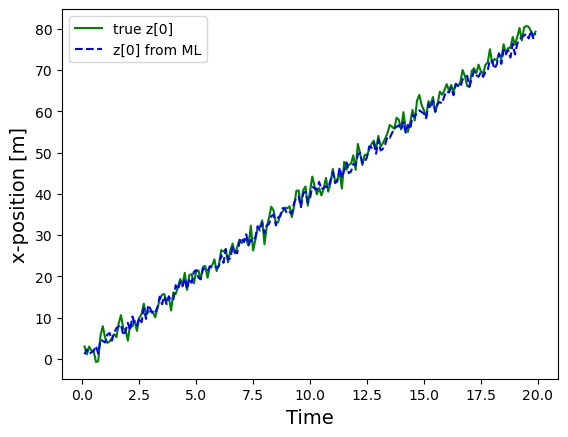

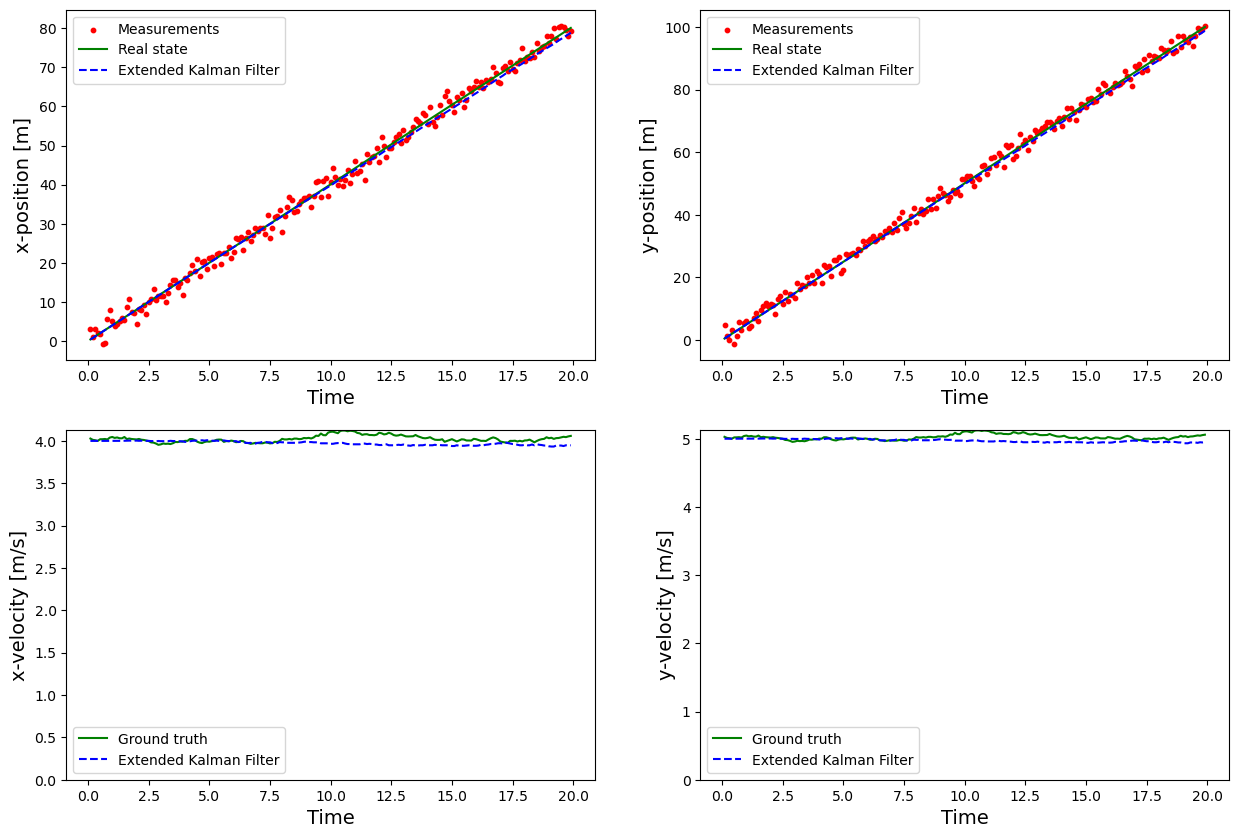

In [28]:

# ML parameters
f=8.6e8
lmb = 3e8/f
print(f'lmb:{lmb}')
ml_resol=2*lmb
std=0.5e0 #extremely important !0.5 is best, 1 is worse (larger, worse)
# array paramters
N=10 # number of elements
d=0.25*lmb # distance between 2 adjacent elements
arr_dim=d*(N-1) # dimension of the array
arr=array(N,arr_dim,0) # array elements location
# Trajectory Parameters
X0=np.array([0,0,4,5]).reshape(4,1)
Length= 200
dt = 0.1
F = np.array([[1, 0, dt, 0], [0, 1, 0, dt],[0,0,1,0],[0,0,0,1]])
H=np.array([[1.,0,0,0],[0,1,0,0]])  
# Process Noise Covariance
sv = 0.1
G = np.matrix([[0.5*dt**2],
           [0.5*dt**2],
           [dt],
           [dt]])
Q = G*G.T*sv**2
Q = np.array(Q)
R = 3.*np.eye(2)

#init
# x0=np.random.multivariate_normal(mean=(0,0,2,3),cov=P).reshape(4,1)
# x0_EKF =np.array([0,0,3,5.1]).reshape(4,1) #important!
# P0_EKF = 5*np.eye(4)
x0_EKF = X0
P0_EKF=np.zeros([4,4])

real_state, measurements, Phases = GenerateTraj(Length,dt,X0,H,F,Q,R)
z_ML,filter_result_ML = Contant_velocity_KF_ML(itr=Length,dt=dt,x0=x0_EKF,P0=P0_EKF,F=F,H=H,Q=Q,R=R,
                                                lmb=lmb,ml_resol=ml_resol,std=std,arr=arr,flag=2)
print(measurements.shape)

# Compare real z and z estimated from ML
print(z_ML.shape)
plt.figure()
plt.plot(np.arange(1*dt,len(measurements)*dt,dt),measurements[1:,0],label = 'true z[0]',c='g')
plt.plot(np.arange(1*dt,len(measurements)*dt,dt),z_ML[:,0,0],label = 'z[0] from ML',c='b',linestyle='--')
plt.xlabel('Time',fontsize=14)
plt.ylabel('x-position [m]',fontsize=14)
plt.legend()
# plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_6/EKF_ML_z.png')
# plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_6/EKF_ML_z_bad.png')


#plotting result
plot_result(measurements,real_state,filter_result_ML)
# plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_6/EKF_ML_result.png')
# plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_6/EKF_ML_result_bad.png')

In [29]:
def plot_result_compare(measurements,real_state,filter_result,filter_result_ML):
    
    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.scatter(np.arange(1*dt,len(measurements)*dt,dt), measurements[1:,0], label = 'Measurements',c='r',s=10)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,0], label = 'Real state',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,0], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result_ML[1:,0], label = 'Extended Kalman Filter + ML encoder',c='black',linestyle='-.')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('x-position [m]',fontsize=14)
    plt.legend()
    plt.subplot(222)
    plt.scatter(np.arange(1*dt,len(measurements)*dt,dt), measurements[1:,1], label = 'Measurements',c='r',s=10)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,1], label = 'Real state',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,1], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result_ML[1:,1], label = 'Extended Kalman Filter + ML encoder',c='black',linestyle='-.')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('y-position [m]',fontsize=14)
    plt.legend()
    plt.subplot(223)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,2], label = 'Ground truth',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,2], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result_ML[1:,2], label = 'Extended Kalman Filter + ML encoder',c='black',linestyle='-.')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('x-velocity [m/s]',fontsize=14)
    plt.ylim(ymin=3,ymax=6)
    plt.legend()
    plt.subplot(224)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,3], label = 'Ground truth',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,3], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result_ML[1:,3], label = 'Extended Kalman Filter + ML encoder',c='black',linestyle='-.')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('y-velocity [m/s]',fontsize=14)
    plt.ylim(ymin=3,ymax=6)
    plt.legend()


lmb:0.3488372093023256
0.10874155068783449 0.1149493884680361


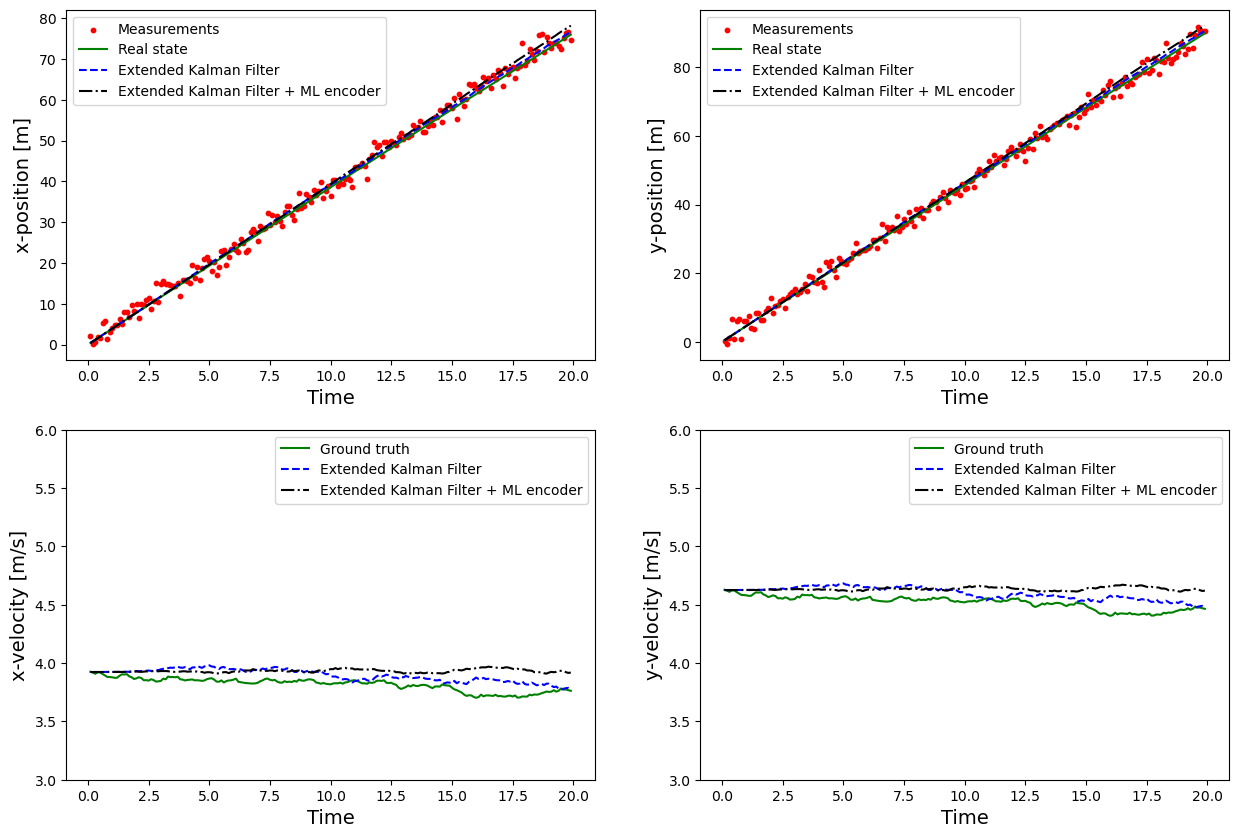

In [30]:
#Exp1
#main

# ML parameters
f=8.6e8
lmb = 3e8/f
print(f'lmb:{lmb}')
ml_resol=2*lmb
std=0.5e0 #extremely important !0.5 is best, 1 is worse (larger, worse)
# array paramters
N=10 # number of elements
d=0.25*lmb # distance between 2 adjacent elements
arr_dim=d*(N-1) # dimension of the array
arr=array(N,arr_dim,0) # array elements location

#EXP
N_exp1=5
Length= 200
obs_list=np.zeros([N_exp1,Length,2])
KF_list=np.zeros([N_exp1,Length,2])
KF_ML_list=np.zeros([N_exp1,Length,2])
for i in range(N_exp1):
    
    # Trajectory Parameters
    v_x=np.random.uniform(3,4)
    v_y=np.random.uniform(4,5)
    X0=np.array([0,0,v_x,v_y]).reshape(4,1)

    dt = 0.1
    F = np.array([[1, 0, dt, 0], [0, 1, 0, dt],[0,0,1,0],[0,0,0,1]])
    H=np.array([[1.,0,0,0],[0,1,0,0]])  
    # Process Noise Covariance
    sv = 0.1
    G = np.matrix([[0.5*dt**2],
               [0.5*dt**2],
               [dt],
               [dt]])
    Q = G*G.T*sv**2
    Q = np.array(Q)
    R = 3.*np.eye(2)
    
    
    #init
    x0_EKF = X0
    P0_EKF=np.zeros([4,4])

    real_state, measurements, Phases = GenerateTraj(Length,dt,X0,H,F,Q,R)
    z,filter_result = Contant_velocity_KF_ML(itr=Length,dt=dt,x0=x0_EKF,P0=P0_EKF,F=F,H=H,Q=Q,R=R,
                                                    lmb=lmb,ml_resol=ml_resol,std=std,arr=arr,flag=1)
    #EKF + ML encoder
    #ML Encoder mse
#     phase_pre=Calcphases(z, arr,lmb,0)
    
    #
#     R_EKF=np.array([[ML_MSE_x,0],[0,ML_MSE_y]])
    R_EKF=R
    z_ML,filter_result_ML = Contant_velocity_KF_ML(itr=Length,dt=dt,x0=x0_EKF,P0=P0_EKF,F=F,H=H,Q=Q,R=R_EKF,
                                                    lmb=lmb,ml_resol=ml_resol,std=std,arr=arr,flag=2)

    
    #plotting result
    if(i==0):
        plot_result_compare(measurements,real_state,filter_result,filter_result_ML)
        # plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_6/EKF_ML_result.png')
        
    # Storing 
    obs_list[i,:,:]=measurements[:,0:2].reshape(Length,2)
    KF_list[i,:,:]=filter_result[:,0:2].reshape(Length,2)
    KF_ML_list[i,:,:]=filter_result_ML[:,0:2].reshape(Length,2)


obs_list=obs_list.reshape(-1,2)
KF_list=KF_list.reshape(-1,2)
KF_ML_list=KF_ML_list.reshape(-1,2)
KF_MSE=MSE_error(obs_list,KF_list)
KF_ML_MSE=MSE_error(obs_list,KF_ML_list)
print(KF_MSE,KF_ML_MSE)

In [31]:
print(f'KF_MSE:{todB(KF_MSE)}[dB],KF_ML_MSE:{todB(KF_ML_MSE)}[dB]')

KF_MSE:-9.636044781177565[dB],KF_ML_MSE:-9.394933348397988[dB]
